In [5]:
# Lidar com dataframes.
import numpy as np
import pandas as pd

import re

import requests
from bs4 import BeautifulSoup

import spacy
from spacy import displacy
pln = spacy.load('pt_core_news_sm')

# Lidar com gráficos.
import matplotlib.pyplot as plt
import seaborn as sns

data_external = "../data/external/"
data_interim = "../data/interim/"
data_processed = "../data/processed/"

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)

# load the autoreload extension
%load_ext autoreload

# Set extension to reload modules every time before executing code
%autoreload 2

## Raspagem do site

In [3]:
def html_para_df_processos(soup):
    df_processos = {}

    for processo, metadados, ementa in zip(soup.select("span.label-processo"), soup.select("dl.dl-horizontal"), soup.select("blockquote")):
        df_processos[processo.get_text()] = [metadados, ementa.get_text()]

    df_processos = pd.DataFrame.from_dict(df_processos, orient="index").reset_index()
    df_processos.rename(columns={"index":"PROCESSO", 0:"METADADO", 1:"EMENTA"}, inplace=True)

    coluna_metadados = []
    metadado = df_processos["METADADO"][0].find_all(['dt'])
    for dado in metadado:
        coluna_metadados.append(dado.get_text())
        
    coluna_metadados_texto = {}
    for i, processo in enumerate(df_processos["METADADO"]):
        metadado_texto = processo.find_all(['dd'])
        conteudo = {}
        for j, texto in enumerate(metadado_texto):
            conteudo[coluna_metadados[j]]= texto.get_text()
        coluna_metadados_texto[i] = conteudo

    df_processos.drop(["METADADO"], axis=1, inplace=True)

    df_metadados = pd.DataFrame.from_dict(coluna_metadados_texto, orient="index")
    
    df_metadados.rename(columns={'Classe':'CLASSE', 'Assunto(s)':'ASSUNTO', 'Competência':'COMPETENCIA',
                                 'Relator':'RELATOR', 'Data Autuação':'DATA'}, inplace=True)

    df_processos = pd.concat([df_processos, df_metadados], axis=1)

    df_processos["TEM_BB"] = np.where(df_processos["EMENTA"].apply(str.lower).str.contains("banco do brasil"), 1, 0)
    
    df_processos = df_processos[['PROCESSO', 'CLASSE', 'ASSUNTO', 'COMPETENCIA', 'RELATOR', 'DATA', 'TEM_BB','EMENTA']]
    
    df_processos["DATA"] = pd.to_datetime(df_processos["DATA"], dayfirst=True)
    
    df_processos["SAFRA_MES"] = ((df_processos["DATA"].dt.year.astype(str) +
                                  (df_processos["DATA"].dt.month.astype(str).str.pad(width=2, side='left', fillchar='0')))).astype(int)

    df_processos["SAFRA_SEMANA"] = ((df_processos["DATA"].dt.year.astype(str) +
                                     (df_processos["DATA"].dt.isocalendar().week.astype(str).str.pad(width=2, side='left', fillchar='0')))).astype(int)
    
    return df_processos

In [4]:
%%time

inicio = 0
fim = 200
url_status = 200

while inicio < 1000:
    html_tj = requests.get("http://jurisprudencia.tjto.jus.br/consulta?q=PASEP+LEGITIMIDADE&start="+str(inicio)+"&rows="+str(fim))
    encoding = html_tj.encoding if 'charset' in html_tj.headers.get('content-type', '').lower() else None
    soup = BeautifulSoup(html_tj.text, 'html.parser', from_encoding=encoding)
    if inicio == 0:
        df_processos = html_para_df_processos(soup)
    else:
        df_temp = html_para_df_processos(soup)
        df_processos = pd.concat([df_processos, df_temp], axis=0)
    inicio += fim

df_processos.drop_duplicates(inplace=True)

# Tratamento de erros
df_processos["CLASSE"].replace("ApelaÃ§Ã£o CÃ­vel", "Apelação Cível", inplace=True)
df_processos["RELATOR"].replace("JOSÃ RIBAMAR MENDES JÃNIOR", "JOSÉ RIBAMAR MENDES JÚNIOR", inplace=True)
df_processos["RELATOR"].replace("JOSÃ DE MOURA FILHO", "JOSÉ DE MOURA FILHO", inplace=True)

print(f"""
    Total de Registros: {len(df_processos)}
    Registros com "Banco do Brasil": {len(df_processos[df_processos["EMENTA"].apply(str.lower).str.contains("banco do brasil")])}
    """)


    Total de Registros: 964
    Registros com "Banco do Brasil": 583
    
Wall time: 24.8 s


### Exportação dos dados em csv

In [8]:
df_processos.to_parquet(data_external+'df_processos.pqt', index=False)
df_processos.to_excel(data_external+'df_processos.xlsx', encoding='utf_8_sig', index=False)

## Análise descritiva

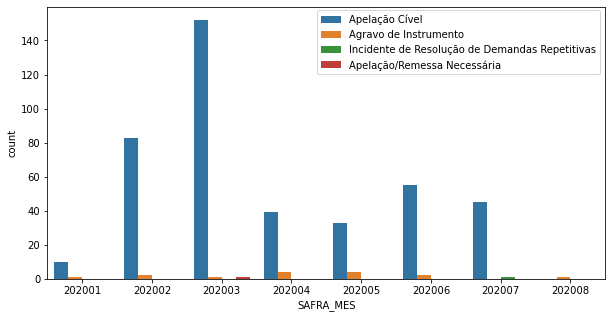

In [29]:
df_processos_2020 = df_processos.loc[df_processos['SAFRA_MES']>=202001,:]

plt.figure(figsize=(10,5))
ax = sns.countplot(x="SAFRA_MES", hue="CLASSE", data=df_processos_2020)
plt.legend(bbox_to_anchor=[0.99, 0.87], loc='center right', borderaxespad=0);

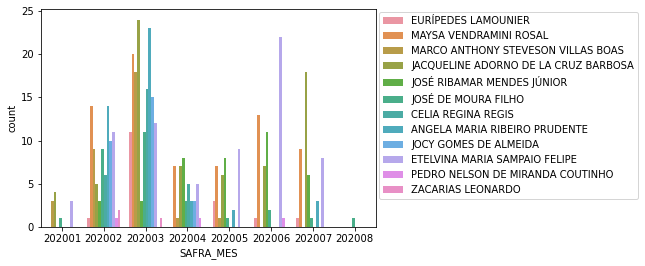

In [30]:
ax = sns.countplot(x="SAFRA_MES", hue="RELATOR", data=df_processos_2020)
plt.legend(bbox_to_anchor=(1.01, 0.99),borderaxespad=0);

## Importação de relatório TJTO

In [94]:
df_report = pd.read_excel(data_external+"julgamentos_pasep.xlsx")
df_report.columns = df_report.columns.str.strip()
df_report.head()

,Processo,Turma,Câmara,Relator,Unan.,Fav.,Data Jul.,Decisão,Fundamento
0,334709220198272729,5ª,2ª,EURÍPEDES LAMOUNIER,S,N,2020-06-25,"Cassar sentença, reconhecer a legitimidade do BB","art. 5º da Lei Complementar nº 8/1970 e no art. 12, incs. I e III, do Decreto nº 9.978, de 20 de agosto de 2019, que revogou o Decreto 4.751/2003"
1,311683220198270000,5ª,2ª,EURÍPEDES LAMOUNIER,S,N,2020-06-25,"Cassar sentença, reconhecer a legitimidade do BB","art. 5º da Lei Complementar nº 8/1970 e no art. 12, incs. I e III, do Decreto nº 9.978, de 20 de agosto de 2019, que revogou o Decreto 4.751/2003"
2,310323520198270000,5ª,2ª,EURÍPEDES LAMOUNIER,S,N,2020-06-25,"Cassar sentença, reconhecer a legitimidade do BB","art. 5º da Lei Complementar nº 8/1970 e no art. 12, incs. I e III, do Decreto nº 9.978, de 20 de agosto de 2019, que revogou o Decreto 4.751/2003"
3,187728120198272729,5ª,2ª,EURÍPEDES LAMOUNIER,S,N,2020-06-25,"Cassar sentença, reconhecer a legitimidade do BB","art. 5º da Lei Complementar nº 8/1970 e no art. 12, incs. I e III, do Decreto nº 9.978, de 20 de agosto de 2019, que revogou o Decreto 4.751/2003"
4,114163520198272729,5ª,2ª,EURÍPEDES LAMOUNIER,S,N,2020-06-25,"Cassar sentença, reconhecer a legitimidade do BB","art. 5º da Lei Complementar nº 8/1970 e no art. 12, incs. I e III, do Decreto nº 9.978, de 20 de agosto de 2019, que revogou o Decreto 4.751/2003"


### Transformando os identificadores dos processos


In [95]:
df_processos["PROCESSO_EDIT"] = df_processos["PROCESSO"].astype(str)
df_processos["PROCESSO_EDIT"] = df_processos["PROCESSO_EDIT"].str.replace("-", "")
df_processos["PROCESSO_EDIT"] = df_processos["PROCESSO_EDIT"].str.replace(".", "")
df_processos["PROCESSO_EDIT"] = df_processos["PROCESSO_EDIT"].apply(int)

df_processos = df_processos[['PROCESSO', 'PROCESSO_EDIT', 'CLASSE', 'ASSUNTO', 'COMPETENCIA', 'RELATOR', 'DATA', 'TEM_BB', 'EMENTA', 'SAFRA_MES', 'SAFRA_SEMANA']]
df_processos.head(2)

,PROCESSO,PROCESSO_EDIT,CLASSE,ASSUNTO,COMPETENCIA,RELATOR,DATA,TEM_BB,EMENTA,SAFRA_MES,SAFRA_SEMANA
0,0033470-92.2019.8.27.2729,334709220198272729,Apelação Cível,"PASEP, Contribuições Sociais, Contribuições, DIREITO TRIBUTÁRIO",TURMAS DAS CAMARAS CIVEIS,EURÍPEDES LAMOUNIER,2020-05-13,1,"\r\nAPELAÇÃO CÍVEL - AÇÃO DE INDENIZAÇÃO POR DANOS MATERIAIS E MORAIS - SUPOSTOS DESFALQUES NA CONTA PASEP - LEGITIMIDADE PASSIVA BANCO DO BRASIL RECONHECIDA. SENTENÇA CASSADA.\r\nVersando a demanda sobre supostos desfalques ocorridos em conta vinculada ao PASEP, o Banco do Brasil é parte legítima para figurar polo passivo, de acordo com o disposto",202005,202020
1,0031168-32.2019.8.27.0000,311683220198270000,Apelação Cível,"PASEP, Contribuições Sociais, Contribuições, DIREITO TRIBUTÁRIO",TURMAS DAS CAMARAS CIVEIS,EURÍPEDES LAMOUNIER,2019-10-29,1,"APELAÇÃO CÍVEL - INDENIZATÓRIA - SAQUES EM CONTAS VINCULADAS AO PASEP - LEGITIMIDADE PASSIVA DO BANCO DO BRASIL S/A.\r\nVersando a demanda exclusivamente sobre supostos desfalques ocorridos em conta vinculada ao PASEP e a má-gestão dos valores depositados nesta, conforme descrito na inicial, resta evidente a legitimidade passiva do Banco do Brasil",201910,201944


In [112]:
df_merge = df_report.merge(df_processos, how="inner", right_on="PROCESSO_EDIT", left_on="Processo")

df_merge.dropna(axis=0, subset=['Decisão'], inplace=True)

print(f"""Qtd de processos no portal: {len(df_processos)}
Qtd de processos no report: {len(df_report)}
Qtd após left join: {len(df_merge)}
""")

Qtd de processos no portal: 964
Qtd de processos no report: 18
Qtd após left join: 18



In [115]:
df_merge = df_merge[['PROCESSO', 'Turma', 'Câmara', 'RELATOR', 'Unan.', 'Fav.', 'Data Jul.', 'DATA', 'Decisão', 'Fundamento', 'CLASSE', 'ASSUNTO', 'COMPETENCIA', 'TEM_BB', 'EMENTA', 'SAFRA_MES']]
df_merge.sort_values(by="PROCESSO").head(2)

,PROCESSO,Turma,Câmara,RELATOR,Unan.,Fav.,Data Jul.,DATA,Decisão,Fundamento,CLASSE,ASSUNTO,COMPETENCIA,TEM_BB,EMENTA,SAFRA_MES
8,0000926-60.2019.8.27.2726,2ª,2ª,MARCO ANTHONY STEVESON VILLAS BOAS,S,N,2020-04-15,2020-02-17,"Cassar sentença, reconhecer a legitimidade do BB",O Banco do Brasil S.A. possui legitimidade para figurar no polo passivo de ação na qual se discute eventual falha na prestação do serviço,Apelação Cível,"Cobrança, Inadimplemento, Obrigações, DIREITO CIVIL",TURMAS DAS CAMARAS CIVEIS,1,"EMENTA\r\n1. APELAÇÃO CÍVEL. AÇÃO DE INDENIZAÇÃO POR DANOS MORAIS E MATERIAIS. CONTA VINCULADA AO PASEP. SAQUES/DESFALQUES. ATUALIZAÇÃO NA CONTA CONFORME DIRETRIZES ESTABELECIDAS PELO CONSELHO DIRETOR. LEGITIMIDADE DO BANCO DO BRASIL S.A.\r\n1.1. O Banco do Brasil S.A., em se tratando de conta vinculada ao PASEP, é o órgão responsável por processar as",202002
5,0001334-03.2019.8.27.2742,5ª,2ª,EURÍPEDES LAMOUNIER,S,N,2020-06-25,2020-03-23,"Cassar sentença, reconhecer a legitimidade do BB","art. 5º da Lei Complementar nº 8/1970 e no art. 12, incs. I e III, do Decreto nº 9.978, de 20 de agosto de 2019, que revogou o Decreto 4.751/2003",Apelação Cível,"PASEP, Contribuições Sociais, Contribuições, DIREITO TRIBUTÁRIO, Acidente de Trânsito, Indenização por Dano Material, Responsabilidade Civil, DIREITO CIVIL, Por invalidez, Indenização por Dano Moral, Responsabilidade Civil, DIREITO CIVIL",TURMAS DAS CAMARAS CIVEIS,1,APELAÇÃO CÍVEL - AÇÃO DE INDENIZAÇÃO POR DANOS MATERIAIS E MORAIS - SUPOSTOS DESFALQUES NA CONTA PASEP - LEGITIMIDADE PASSIVA BANCO DO BRASIL RECONHECIDA. INSATISFAÇÃO DA PARTE AUTORA QUANTO À CORREÇÃO MONETÁRIA - AUSÊNCIA DE CLAREZA DO PEDIDO - EMENDA DA INICIAL NECESSÁRIA - PROCESSO ANULADO - SENTENÇA CASSADA.\r\nVersando a demanda sobre supostos,202003


In [125]:
df_merge_grouped = df_merge.groupby(["SAFRA_MES", "Decisão"]).agg({"PROCESSO":"count"}).rename(columns={"PROCESSO":"qtd_processos"}).reset_index()
df_merge_grouped.sort_values(by=["SAFRA_MES", "Decisão"], ascending=True, inplace=True)

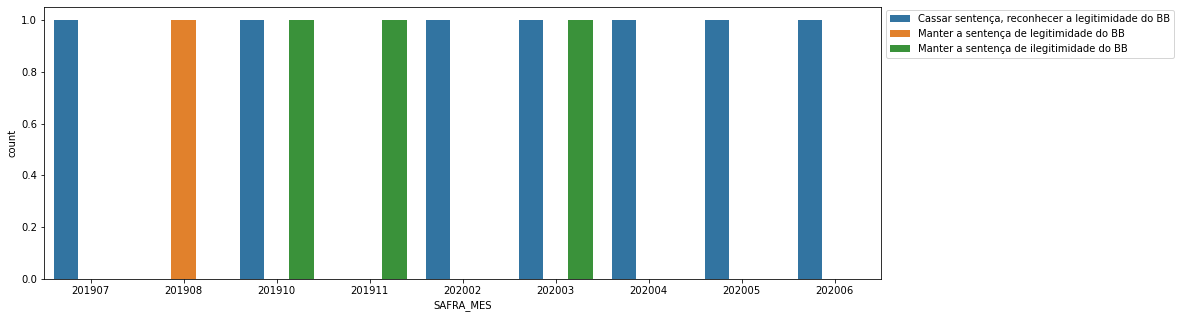

In [138]:
plt.figure(figsize=(15,5))
sns.countplot(x="SAFRA_MES", data=df_merge_grouped, hue="Decisão")
plt.legend(bbox_to_anchor=[1.35, 0.90], loc='right', borderaxespad=0);